# <a id='toc1_'></a>[Forecsting remainders with OLS](#toc0_)

## <a id='toc1_1_'></a>[Libraries](#toc0_)

In [3]:
#install.packages("C:/Users/madsh/Downloads/path/to/withr_2.1.2.tar.gz", repos = NULL, type = "source")

#install.packages('forecast')
#install.packages('doParallel')
#install.packages('xgboost')

library(tidyverse)
library(forecast)
library(ggplot2)
library(dplyr)
library(data.table)
library(IRdisplay)

library(foreach)
library(doParallel)

library(caret)
library(randomForest)
library(xgboost)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Vedhæfter pakke: 'data.table'


De følgende objekter er maskerede fra 'package:lubridate':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


De følgende objekter er maskerede fra 'package:dplyr':

    between, first, last


Det følgende objekt er maskeret fra 'package:purrr':

    transpose



Vedhæfter pakke: 'foreach'


De følgende obj

## <a id='toc1_2_'></a>[Custom functions](#toc0_)

### <a id='toc1_2_1_'></a>[Display tables](#toc0_)

In [4]:
# Custom display function for the first and last 5 rows or full table if <= 20 rows
display_limited <- function(dt) {
  n <- nrow(dt)
  
  # If there are 20 or fewer rows, display the full table
  if (n <= 20) {
    limited_dt <- dt
  } else {
    # Otherwise, concatenate the first 5 rows, '...' and the last 5 rows
    limited_dt <- rbind(head(dt, 5), as.list(rep("...", ncol(dt))), tail(dt, 5))
  }
  
  # Generate raw HTML manually
  html_output <- paste0(
    "<table border='1' style='border-collapse:collapse;'>",
    "<thead><tr>",
    paste0("<th>", colnames(limited_dt), "</th>", collapse = ""),
    "</tr></thead>",
    "<tbody>",
    paste0(
      apply(limited_dt, 1, function(row) {
        paste0("<tr>", paste0("<td>", row, "</td>", collapse = ""), "</tr>")
      }),
      collapse = ""
    ),
    "</tbody></table>"
  )
  
  # Display the HTML in the Jupyter notebook
  display_html(html_output)
}


### <a id='toc1_2_2_'></a>[Calculate metrics](#toc0_)

In [5]:
calculate_metrics <- function(T_t, R_hat_t, individual) {
  # Ensure the inputs are numeric vectors and individual is a dataframe
  if (!is.numeric(T_t) || !is.numeric(R_hat_t)) {
    stop("Both T_t and R_hat_t need to be numeric vectors.")
  }
  
  # Calculate metrics
  mae <- mean(abs(T_t - R_hat_t), na.rm = TRUE)
  rmse <- sqrt(mean((T_t - R_hat_t)^2, na.rm = TRUE))
  mape <- mean(abs((T_t - R_hat_t) / T_t), na.rm = TRUE) * 100
  r_squared <- ifelse(all(T_t == R_hat_t), 1, summary(lm(T_t ~ R_hat_t))$r.squared)
  
  # Create a data frame to hold the metrics and values
  metrics_table <- data.frame(
    MAE = mae,
    RMSE = rmse,
    MAPE = mape,
    R_squared = r_squared
  )
  
  # Return the metrics table
  return(metrics_table)
}

### <a id='toc1_2_3_'></a>[Data Preparation](#toc0_)

In [6]:
prepare_X_t <- function(individual) {
  # Ensure the input is a dataframe
  if (!is.data.frame(individual)) {
    stop("The input must be a dataframe.")
  }
  
  # Extract hour from start_time and create a 'time_of_day' column
  individual$time_of_day <- format(as.POSIXct(individual$HourDK), "%H:%M:%S")
  
  # Exclude specified columns but keep 'time_of_day'
  X_t <- subset(individual, select = -c(HourDK, GrossConsumptionMWh))
  
  # Convert month, weekday, and time_of_day to factors with a reference category
  X_t$month <- relevel(as.factor(X_t$MonthOfYear), ref = "December")  # Set December as reference
  X_t$weekday <- relevel(as.factor(X_t$DayOfWeek), ref = "Sunday")   # Set Sunday as reference 
  X_t$time_of_day <- relevel(as.factor(X_t$Hour), ref = "0")         # Set 23 (11 PM) as reference

  # Remove original 'MonthOfYear', 'DayOfWeek', and 'Hour' columns to avoid duplication
  X_t <- subset(X_t, select = -c(MonthOfYear, DayOfWeek, Hour))
  
  # Create dummy variables for all factor columns (excluding reference levels)
  X_t <- model.matrix(~ . - 1, data = X_t)
  
  # Find the column indices for numerical columns AFTER creating dummy variables
  num_cols <- grep("^(Electric cars|Plug-in hybrid cars|humidity_past1h|temp_mean_past1h|wind_speed_past1h|EL_price)", colnames(X_t))
  
  # Standardize selected numerical columns
  X_t[, num_cols] <- apply(X_t[, num_cols], 2, 
                           function(x) (x - min(x)) / (max(x) - min(x)))
  
  # Return the processed dataframe
  return(as.data.frame(X_t))
}


### <a id='toc1_2_4_'></a>[Lag and Align data by \\(h\\) (horizon)](#toc0_)

In [7]:
lag_and_align_data <- function(X_t, R_t, h = 1) {
  # Validate inputs
  if (!is.numeric(R_t)) {
    stop("R_t should be a numeric vector.")
  }
  if (!is.data.frame(X_t) && !is.matrix(X_t)) {
    stop("X_t should be a dataframe or a matrix.")
  }
  if (!is.numeric(h) || h < 1) {
    stop("h should be a positive integer.")
  }
  
  # Convert X_t to a dataframe if it's a matrix
  if (is.matrix(X_t)) {
    X_t <- as.data.frame(X_t)
  }
  
  # Align R_t with the lagged X_t
  # Shift R_t by h positions to align with X_t from the previous timestep
  R_t_aligned <- R_t[(h + 1):length(R_t)]
  
  # Keep X_t up to the second to last row, so it aligns with the shifted R_t
  X_t_aligned <- X_t[1:(nrow(X_t) - h), ]
  
  # Return the aligned datasets
  list(X_t = X_t_aligned, R_t = R_t_aligned)
}

### <a id='toc1_2_5_'></a>[Plot actual vs estimated](#toc0_)

In [8]:
plot_actual_vs_estimated <- function(R_t, R_hat_t, individual) {
  # Validate input
  if (!is.numeric(R_t) || !is.numeric(R_hat_t)) {
    stop("R_t and R_hat_t should be numeric vectors.")
  }
  if (!is.data.frame(individual)) {
    stop("individual should be a dataframe.")
  }
    
  # Create the plot
  plot(R_t, type = 'l', col = 'blue', xlab = "Time", ylab = "Value", 
       main = "Actual vs. Estimated Time Series\nelvarme: %s, zip_code: %s")
  lines(R_hat_t, type = 'l', col = 'red')
  legend("topleft", legend = c("Actual", "Estimated"), col = c("blue", "red"), lty = 1)
}

## <a id='toc1_3_'></a>[Loading data](#toc0_)

In [9]:
##### Setting workign directory and loadign data #####
base_path <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data Cleaning"
setwd(base_path)
data <- fread(paste0(base_path,"/Output_file.csv"))
MSTL <- fread(paste0(base_path,"/MSTL_decomp_results.csv"))

## <a id='toc1_4_'></a>[Parameters](#toc0_)

In [10]:
#train_size    <- 17544 #2 year training set
train_size    <- 8784  #1 year training set
num_timesteps <- 720
h             <- 8784
total_size    <- nrow(data)-h
nrounds       <- 100
set.seed(42) 

### <a id='toc1_4_1_'></a>[Data preparation](#toc0_)

In [11]:
individual <- data
X_t <- prepare_X_t(as.data.frame(individual))
T_t <- as.matrix(MSTL$Trend, nrow = nrow(MSTL), ncol = 1)

lag_and_align <- lag_and_align_data(X_t, T_t, h = h)

X_t <- as.matrix(lag_and_align$X_t)
T_t <- as.numeric(lag_and_align$R_t)

In [17]:
T_t

[1] 4110.457 4110.472 4110.486 4110.501 4110.515 4110.530 4110.544 4110.559
    [9] 4110.573 4110.588 4110.602 4110.617 4110.631 4110.646 4110.660 4110.675
   [17] 4110.689 4110.704 4110.718 4110.733 4110.747 4110.762 4110.776 4110.791
   [25] 4110.805 4110.820 4110.834 4110.849 4110.863 4110.878 4110.892 4110.907
   [33] 4110.921 4110.936 4110.950 4110.964 4110.979 4110.993 4111.008 4111.022
   [41] 4111.037 4111.051 4111.066 4111.080 4111.095 4111.109 4111.124 4111.138
   [49] 4111.153 4111.167 4111.182 4111.196 4111.211 4111.225 4111.240 4111.254
   [57] 4111.269 4111.283 4111.298 4111.312 4111.327 4111.341 4111.356 4111.370
   [65] 4111.385 4111.399 4111.414 4111.428 4111.443 4111.457 4111.471 4111.486
   [73] 4111.500 4111.515 4111.529 4111.544 4111.558 4111.573 4111.587 4111.602
   [81] 4111.616 4111.631 4111.645 4111.660 4111.674 4111.689 4111.703 4111.718
   [89] 4111.732 4111.747 4111.761 4111.776 4111.790 4111.805 4111.819 4111.834
   [97] 4111.848 4111.863 4111.877 4111.892 4111.906 4111.921 4111.935 4111.950
  [105] 4111.964 4111.978 4111.993 4112.007 4112.022 4112.036 4112.051 4112.065
  [113] 4112.080 4112.094 4112.109 4112.123 4112.138 4112.152 4112.167 4112.181
  [121] 4112.196 4112.210 4112.225 4112.239 4112.254 4112.268 4112.283 4112.297
  [129] 4112.312 4112.326 4112.341 4112.355 4112.370 4112.384 4112.399 4112.413
  [137] 4112.428 4112.442 4112.457 4112.471 4112.485 4112.500 4112.514 4112.529
  [145] 4112.543 4112.558 4112.572 4112.587 4112.601 4112.616 4112.630 4112.645
  [153] 4112.659 4112.674 4112.688 4112.703 4112.717 4112.732 4112.746 4112.761
  [161] 4112.775 4112.790 4112.804 4112.819 4112.833 4112.848 4112.862 4112.877
  [169] 4112.891 4112.906 4112.920 4112.935 4112.949 4112.964 4112.978 4112.992
  [177] 4113.007 4113.021 4113.036 4113.050 4113.065 4113.079 4113.094 4113.108
  [185] 4113.123 4113.137 4113.152 4113.166 4113.181 4113.195 4113.210 4113.224
  [193] 4113.239 4113.253 4113.268 4113.282 4113.297 4113.311 4113.326 4113.340
  [201] 4113.355 4113.369 4113.384 4113.398 4113.413 4113.427 4113.442 4113.456
  [209] 4113.471 4113.485 4113.499 4113.514 4113.528 4113.543 4113.557 4113.572
  [217] 4113.586 4113.601 4113.615 4113.630 4113.644 4113.659 4113.673 4113.688
  [225] 4113.702 4113.717 4113.731 4113.746 4113.760 4113.775 4113.789 4113.804
  [233] 4113.818 4113.833 4113.847 4113.862 4113.876 4113.891 4113.905 4113.920
  [241] 4113.934 4113.949 4113.963 4113.978 4113.992 4114.006 4114.021 4114.035
  [249] 4114.050 4114.064 4114.079 4114.093 4114.108 4114.122 4114.137 4114.151
  [257] 4114.166 4114.180 4114.195 4114.209 4114.224 4114.238 4114.253 4114.267
  [265] 4114.282 4114.296 4114.311 4114.325 4114.340 4114.354 4114.369 4114.383
  [273] 4114.398 4114.412 4114.427 4114.441 4114.456 4114.470 4114.485 4114.499
  [281] 4114.513 4114.528 4114.542 4114.557 4114.571 4114.586 4114.600 4114.615
  [289] 4114.629 4114.644 4114.658 4114.673 4114.687 4114.702 4114.716 4114.731
  [297] 4114.745 4114.760 4114.774 4114.789 4114.803 4114.818 4114.832 4114.847
  [305] 4114.861 4114.876 4114.890 4114.905 4114.919 4114.934 4114.948 4114.963
  [313] 4114.977 4114.992 4115.006 4115.020 4115.035 4115.049 4115.064 4115.078
  [321] 4115.093 4115.107 4115.122 4115.136 4115.151 4115.165 4115.180 4115.194
  [329] 4115.209 4115.223 4115.238 4115.252 4115.267 4115.281 4115.296 4115.310
  [337] 4115.325 4115.339 4115.354 4115.368 4115.383 4115.397 4115.412 4115.426
  [345] 4115.441 4115.455 4115.470 4115.484 4115.499 4115.513 4115.527 4115.542
  [353] 4115.556 4115.571 4115.585 4115.600 4115.614 4115.629 4115.643 4115.658
  [361] 4115.672 4115.687 4115.701 4115.716 4115.730 4115.745 4115.759 4115.774
  [369] 4115.788 4115.803 4115.817 4115.832 4115.846 4115.861 4115.875 4115.890
  [377] 4115.904 4115.919 4115.933 4115.948 4115.962 4115.977 4115.991 4116.006
  [385] 4116.020 4116.034 4116.049 4116.063 4116.078 4116.092 4116.107 4116.121
  [393] 4116.136 4116.150 4116.165 4116.179 4116.194 4116.208 4116.223 4116.237
  [4

## <a id='toc1_5_'></a>[Hyper parameter tuning](#toc0_)

In [38]:
# Simple train-validation split for hyperparameter tuning
train_index <- 1:train_size
val_index <- (train_size + 1):(train_size + num_timesteps)

dtrain <- xgb.DMatrix(data = X_t[train_index, ], label = T_t[train_index])
dval <- xgb.DMatrix(data = X_t[val_index, ], label = T_t[val_index])

watchlist <- list(train = dtrain, eval = dval)

tune_grid <- expand.grid(
  eta = c(0.01, 0.05, 0.1),
  max_depth = c(3, 6, 9),
  subsample = c(0.6, 0.8, 1.0),
  colsample_bytree = c(0.6, 0.8, 1.0)
)

best_params <- NULL
best_rmse <- Inf

for (i in 1:nrow(tune_grid)) {
  params <- list(
    objective = "reg:squarederror",
    eta = tune_grid$eta[i],
    max_depth = tune_grid$max_depth[i],
    subsample = tune_grid$subsample[i],
    colsample_bytree = tune_grid$colsample_bytree[i]
  )
  
  xgb_model <- xgb.train(
    params = params,
    data = dtrain,
    nrounds = nrounds,
    watchlist = watchlist,
    early_stopping_rounds = 5,
    verbose = 0
  )
  
  if (xgb_model$best_score < best_rmse) {
    best_rmse <- xgb_model$best_score
    best_params <- params
  }
}

### <a id='toc1_5_1_'></a>[Fitting](#toc0_)

In [39]:
no_cores <- detectCores() - 1
cl <- makeCluster(no_cores)
registerDoParallel(cl)

results <- foreach(j = seq(1, nrow(X_t) - train_size, by = num_timesteps), .combine = 'c', .packages = 'xgboost') %dopar% {
  start_index <- j
  end_index <- j + train_size - 1
  
  train_X_t <- X_t[start_index:end_index, ]
  train_T_t <- T_t[start_index:end_index]
  
  dtrain <- xgb.DMatrix(data = train_X_t, label = train_T_t)
  
  xgb_model <- xgb.train(params = best_params, data = dtrain, nrounds = nrounds)
    
  test_start_index <- end_index + 1
  test_end_index <- min(end_index + num_timesteps, total_size)
  test_X_t <- X_t[test_start_index:test_end_index, , drop = FALSE]
  dtest <- xgb.DMatrix(data = test_X_t)
  
  test_predictions <- predict(xgb_model, newdata = dtest)
  
  num_predictions_to_return <- min(num_timesteps, total_size - test_start_index + 1)
  return(test_predictions[1:num_predictions_to_return])
}
stopCluster(cl)

T_hat_t <- unlist(results)

### <a id='toc1_5_2_'></a>[Calculating metrics](#toc0_)

In [40]:
individual_metrics <- calculate_metrics(tail(T_t, n = length(T_t) - train_size), T_hat_t, data)
display_limited(individual_metrics)

MAE,RMSE,MAPE,R_squared
106.586725670475,132.539767811825,2.66860776393908,0.0328089168366802


In [60]:
T_test_XGB=T_t[(train_size + 1):length(T_t)]
length(T_test_XGB)

[1] 8736

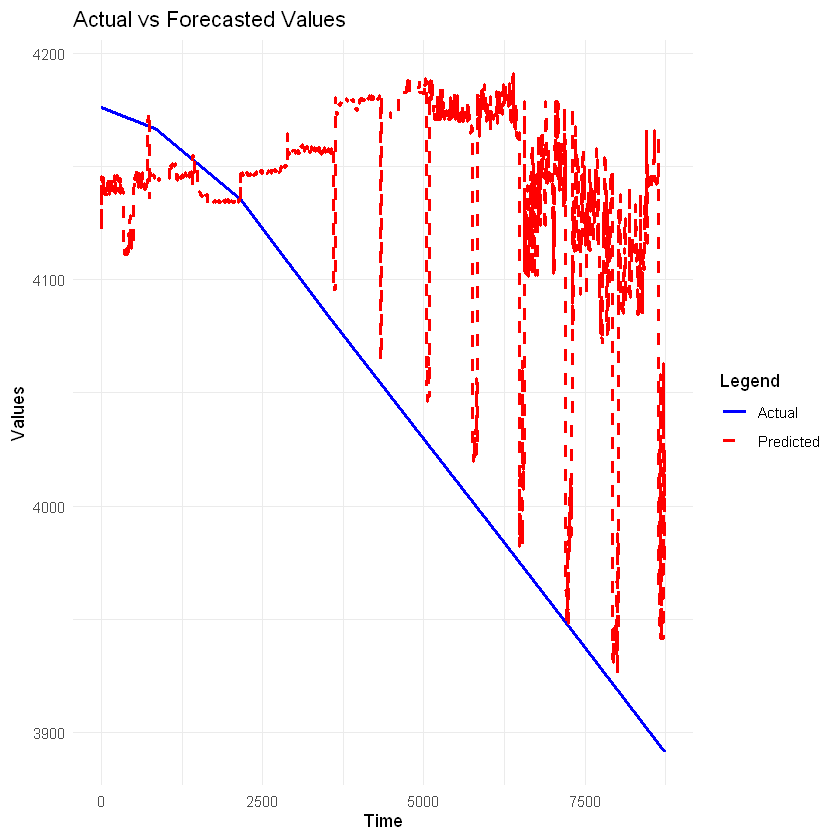

In [61]:
# Create a data frame for plotting
plot_data <- data.frame(
  Time = 1:length(T_test_XGB),  # Assuming sequential time indices
  Actual = T_test_XGB,
  Predicted = T_hat_t  # Your forecasted values
)


# Plot the actual vs. predicted values
ggplot(plot_data, aes(x = Time)) +
  geom_line(aes(y = Actual, color = "Actual"), size = 1) +
  geom_line(aes(y = Predicted, color = "Predicted"), size = 1, linetype = "dashed") +
  labs(title = "Actual vs Forecasted Values",
       x = "Time",
       y = "Values",
       color = "Legend") +
  theme_minimal() +
  scale_color_manual(values = c("Actual" = "blue", "Predicted" = "red"))

In [ ]:
# Define the file path
path_R <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/R_hat_t"
path_M <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/Metrics"
# Automatically generate file names based on the parameters
file_name_R_hat_t <- file.path(path_R, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_XGB_R_hat_t.csv"))
file_name_metrics <- file.path(path_M, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_XGB_Metrics.csv"))



# Save R_hat_t as a CSV file
write.csv(R_hat_t, file = file_name_R_hat_t, row.names = FALSE)

# Save individual_metrics as a CSV file
write.csv(individual_metrics, file = file_name_metrics, row.names = FALSE)


In [ ]:
# Define the file path
path_R <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/R_hat_t"
path_M <- "C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Forecasting-energy-consumption/Data/Results/Boosting/Metrics"
file_name_R_hat_t <- file.path(path_R, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_Boosting_R_hat_t.csv"))
file_name_metrics <- file.path(path_M, paste0("h=", h, "_steps_ahead=", num_timesteps, "_nrounds=", nrounds, "_train_size=", train_size, "_Boosting_Metrics.csv"))

